#Example: Using DistArray for Gaussian Elimination (L-U decomposition)

**Note:** This notebook requires an `IPython.parallel` cluster to be running. Outside the notebook, run:
```
dacluster start -n4
```
***

Gaussian Elimination is an algorithm in Linear Algebra best understood as a series of row operations on the coefficient matrix of a system of linear equations. The method can also be used to calculate the rank, determinant, and inverse of a matrix. The algorithm involves adding multiples of each row to subsequent rows, in order to make the coefficient matrix upper triangular. The resulting system is then solved by back-substitution which is trivial to perform. This algorithm is illustrated in the figure below:<img src="img1.png">

Here **i** refers to the index of the pivot row (started at 1). Please note that much of this example notebook is adapted from [Parallel Gaussian Elimination](https://github.com/prashantmital/ge_utpcse/blob/master/Report.pdf) which is a good starting point for gaining a better understanding of Gaussian Elimination from an computational standpoint.

In this notebook we will demonstrate how to perform GE in *parallel* using the **DistArray API**. The main challenge in parallelizing Gaussian Elimination on a distributed memory machine is that the calculation of each row requires the calculation of all rows that have come before it and therefore concurrency of operations becomes the overriding issue. This bodes well for the client-engine architecture of `IPython.parallel` (and consequently DistArray) as the client can keep track of *pivot* row, while the row transformations can be pushed out to the engines using custom uFuncs. 

We begin with the imports:

In [33]:
# utility imports
from __future__ import print_function
from pprint import pprint
from matplotlib import pyplot as plt

# main imports
import numpy as np
import distarray.globalapi as da
from distarray.plotting import plot_array_distribution

# output goodness
np.set_printoptions(precision=2)

# display figures inline
%matplotlib inline

We now define the parameter space for our study. We will perform GE on matrices that are *block distributed* in any one or both dimensions, while simultaneously varying the size:

In [34]:
distributions = [('n','b'), ('b','n'), ('b','b')]
sizes = [8, 16, 32, 64]
print(distributions)

[('n', 'b'), ('b', 'n'), ('b', 'b')]


Next, we create a context and devise a scheme for generating some synthetic data (in this case a matrix) on which to operate:

In [35]:
context = da.Context()
def synthetic_data_generator(contextobj, datashape=(16, 16), distscheme=('b', 'n')):
    """Return objective matrix with specified size and distribution."""
    distribution = da.Distribution(contextobj, shape=datashape, dist=distscheme)
    _syndata = np.random.random(datashape)
    syndata = contextobj.fromarray(_syndata, distribution=distribution)
    return syndata

In order for the Gaussian Elimination operation to be truly parallel, we need to define a uFunc to perform the desired computation:

In [36]:
def parallel_gauss_elim(darray, pivot_row, k, m):
    """
    Perform in-place gaussian elimination locally on all engines.
    
    Parameters
    ---------
    darray : DistArray
        Handle for the array to be manipulated (global)
    pivot_row : numpy.ndarray 
        Array containing pivot row (global)
    k : integer
        Pivot row index (global)
    m : numpy.ndarray
        Vector containing pivoting factors (global)
    """
    import numpy as np
    
    # retrieve local indices for submatrix that needs to be operated on
    n_rows, n_cols = darray.distribution.global_shape    
    i_slice, j_slice = darray.distribution.local_from_global((slice(k+1, n_rows), 
                                                              slice(k, n_cols)))
    
    # limit the slices using actual size of local array
    n_rows_local, n_cols_local = darray.ndarray.shape
    i_indices, j_indices = (i_slice.indices(n_rows_local), 
                            j_slice.indices(n_cols_local))
    
    # determine which elements of global pivot row correspond to local entries
    _, piv_slice = darray.distribution.global_from_local((slice(0, n_rows_local), 
                                                          slice(*j_indices)))
    
    # limit the slice to the size of the global pivot row
    piv_indices = piv_slice.indices(n_cols)
    
    # determine which elements of global pivot factor vector corresponds to local
    mul_slice, _ = darray.distribution.global_from_local((slice(*i_indices), 
                                                          slice(0, n_cols_local)))
    
    # limit the slice to the size of the global pivot factor vector
    mul_indices = mul_slice.indices(n_rows)
    
    # perform the elimination to create zeros below pivot
    if (i_indices[0] == i_indices[1] or j_indices[0] == j_indices[1]):
        # computation for the local block is done
        return
    else:
        for i, mul in zip(xrange(*i_indices), xrange(*mul_indices)):
            np.subtract(darray.ndarray[i, slice(*j_indices)], 
                        np.multiply(m[mul], pivot_row[slice(*piv_indices)]),
                        out=darray.ndarray[i, slice(*j_indices)])
        return


We want to use a nice syntax for calling out uFunc hence we *register* it with our context (alternatively, we could have just used `Context.apply` which has a more obscure call format):

In [37]:
context.register(parallel_gauss_elim)

All that is left now is to define the high level function that runs on the client and manages the GE operation. Using this function is a way of ensuring synchronicity between the many engines performing this operation. After a pivot row is determined, it is broadcast along with a vector of pivoting factors to the worker engines via the `parallel_gauss_elim` uFunc. Note how we have actually subverted the need to use canonical MPI constructs (in this case, `MPI_Bcast()`) by making use of the fact that our uFunc can accept arbitrary arguments. 

In [38]:
def execute_ge(contextobj, darray):
    N = min(darray.shape)
    for k in range(N-1):
        pivot_factors = (d_array[:, k]/d_array[k, k]).toarray()
        contextobj.parallel_gauss_elim(darray, darray[k, :].toarray(), k, pivot_factors)

In order to enable the reader to better visualize what is happening in this example, we will make the first set of runs with the size fixed at 8, while cycling through the distribution types. We also print out a graphical representation of the distribution of the resulting upper triangular matrices.

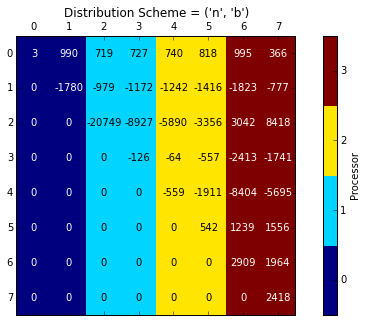

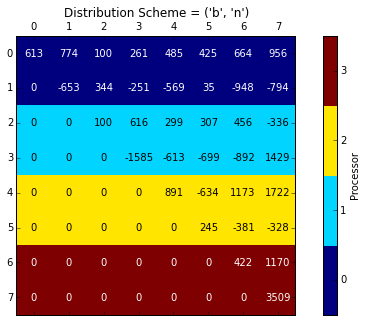

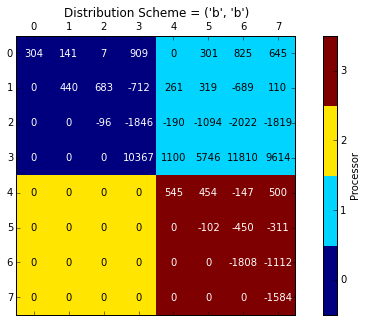

In [39]:
N = sizes[0]
for scheme in distributions:
    d_array = 1000 * synthetic_data_generator(context, datashape=(N,N), distscheme=scheme)
    execute_ge(context, d_array)
    process_coords = [(0, 0), (1, 0), (2, 0), (3, 0)]
    plot_array_distribution(d_array, process_coords, legend=True, 
                            title=str("Distribution Scheme = " + str(scheme)))

Now we write a quick routine that runs through all sizes and distributions and records the runtimes. The resulting information is best represented as a plot the data for which is collected in a Dictionary called `performance_data`. Depending on the contents of your `sizes` vector, the runtimes may very a great deal on this section. To see the progress of execution, the user may choose to disable the `-q` (quiet) option on the `%timeit` magic function. 

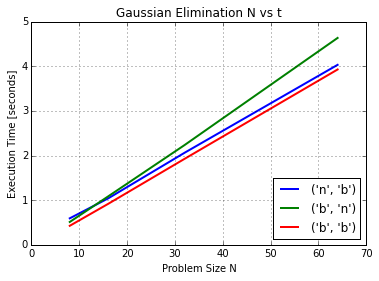

In [40]:
performance_data = dict()
for scheme in distributions:
    performance_data[scheme] = list()
    
for scheme in distributions:
    for N in sizes:
        d_array = 1000 * synthetic_data_generator(context, datashape=(N,N), distscheme=scheme)
        _time = %timeit -o -q execute_ge(context, d_array)
        performance_data[scheme].append(_time.best)
    p1,=plt.plot(sizes, performance_data[scheme], label=str(scheme), linewidth=2)

plt.legend(loc=4)
plt.xlabel('Problem Size N')
plt.ylabel('Execution Time [seconds]')
plt.title('Gaussian Elimination N vs t')
plt.grid(True)

We see that we observe similar performance from all three distributions with a *block-block* map marginally most efficient. 
***